In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from datasets import TextClassifierTrainDataset, TextClassifierInferenceDataset
from dataloaders import get_train_loader, get_inference_loader
from model import TransformerClassifier, DemographicDiscriminator, CombinedModel

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def fpr(y_true, y_pred):
    tot_neg = (y_true == False).sum()
    fp      = ((y_true == False) & (y_pred == True)).sum()
    # print(tot_neg, fp)
    return fp/tot_neg


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, loss_fn, train_dataloader, optimizer, DEVICE):
    model.train()
    losses = 0

    for i, (src, tgt) in enumerate(train_dataloader):
                
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        logits, _ = model(src)

        optimizer.zero_grad()

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        if i % 10 == 0:
            print(f'\rProcessing batch {i} of {len(train_dataloader)}: loss {loss}', end='', flush=True)

    return losses / len(train_dataloader)


def evaluate(model, loss_fn, val_dataloader, idx_to_class, DEVICE):
    model.eval()
    losses = 0

    str_pred = []
    str_true = []
    for i, (src, tgt) in enumerate(val_dataloader):
                
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        logits, _ = model(src)

        # token predictions
        tgt_pred = torch.max(logits, dim=-1).indices  # (T, N)

        # loop over examples in batch
        for x in range(tgt_pred.shape[-1]):

            tgt_x      = tgt[x]
            tgt_pred_x = tgt_pred[x]

            tgt_x_string      = idx_to_class[tgt_x.tolist()]
            tgt_pred_x_string = idx_to_class[tgt_pred_x.tolist()]

            str_true.append(tgt_x_string)
            str_pred.append(tgt_pred_x_string)
        
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        losses += loss.item()
        
        if i % 10 == 0:
            print(f'\rProcessing batch {i} of {len(val_dataloader)}: loss {loss}', end='', flush=True)

    print()
    return losses / len(val_dataloader), np.mean([int(te == pe) for te, pe in zip(str_true, str_pred)]), str_true, str_pred


def evaluate_with_protected_attribute(model, loss_fn, val_dataloader, idx_to_class, idx_to_prot_attr, DEVICE):
    model.eval()
    losses = 0

    str_pred   = []
    str_true   = []
    prot_attrs = []
    for i, (src, tgt, prot_attr) in enumerate(val_dataloader):
                
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        prot_attr = prot_attr.to(DEVICE)

        logits, _ = model(src)

        # token predictions
        tgt_pred = torch.max(logits, dim=-1).indices  # (T, N)

        # loop over examples in batch
        for x in range(tgt_pred.shape[-1]):

            tgt_x       = tgt[x]
            tgt_pred_x  = tgt_pred[x]
            prot_attr_x = prot_attr[x]

            tgt_x_string       = idx_to_class[tgt_x.tolist()]
            tgt_pred_x_string  = idx_to_class[tgt_pred_x.tolist()]
            prot_attr_x_string = idx_to_prot_attr[prot_attr_x.tolist()]
            
            str_true.append(tgt_x_string)
            str_pred.append(tgt_pred_x_string)
            prot_attrs.append(prot_attr_x_string)
        
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        losses += loss.item()
        
        if i % 10 == 0:
            print(f'\rProcessing batch {i} of {len(val_dataloader)}: loss {loss}', end='', flush=True)

    print()
    return losses / len(val_dataloader), np.mean([int(te == pe) for te, pe in zip(str_true, str_pred)]), str_true, str_pred, prot_attrs

In [3]:
# train data 
train_df = pd.read_csv('civility_data/train.tsv', sep='\t')
print(train_df.shape)

# extra_data
extra_df = pd.read_csv('civility_extra_data/labeled_data.tsv', sep='\t')
print(extra_df.shape)

# dev data
dev_df = pd.read_csv('civility_data/dev.tsv', sep='\t')
print(dev_df.shape)

# demog dev: for FPR disparity
demog_dev_df = pd.read_csv('civility_data/mini_demographic_dev.tsv', sep='\t')
demog_dev_df['label'] = 'NOT'
print(demog_dev_df.shape)

(10592, 3)
(24783, 7)
(1324, 4)
(5072, 4)


In [4]:
demog_dev_df.head()

,text,demographic,perspective_score,label
0,People make mistakes. It takes a good person to learn from them. #learning,White,0.041031,NOT
1,"Only one on our road with power, but no cable or internet... Guess I can't have it all.",White,0.061435,NOT
2,I love when baby's yawn I think it's so cute.,White,0.056817,NOT
3,theres so many hoes now that i actually think about it..,White,0.503459,NOT
4,Today is the day Adalynn Alexis will be here! I can't believe that 9 months ago I was the first to know and now it's finally here :))),White,0.092183,NOT


In [5]:
# # train-val-test split
# train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
# train_df.shape, val_df.shape

In [6]:
# create datasets
train_dataset = TextClassifierTrainDataset(
    df = train_df, 
    source_column = 'text', 
    target_column = 'label',
    class_names = train_df['label'].unique().tolist(),
    freq_threshold = 3,
    max_size = None
)
val_dataset = TextClassifierInferenceDataset(
    train_dataset = train_dataset,
    df = dev_df, # val_df, 
    source_column = 'text', 
    target_column = 'label',
)
demog_dev_dataset = TextClassifierInferenceDataset(
    train_dataset = train_dataset,
    df = demog_dev_df, 
    source_column = 'text', 
    target_column = 'label',
    protected_attribute_column = 'demographic',
    protected_attribute_names = demog_dev_df['demographic'].unique().tolist(),
    protected_attribute_source = 'self'
)

In [7]:
text, cls = train_dataset[1]
text_readable, cls_readable = train_dataset.get_readable_tokens(text, cls)
' '.join(text_readable)

"<SOS> @ user seems hard to believe that you stood next to a guy wearing those <UNK> and didn ' t <UNK> but i ' ll take your word for it <EOS>"

In [8]:
# create dataloaders
train_dataloader = get_train_loader(
    dataset = train_dataset, 
    batch_size = 32
)
val_dataloader   = get_inference_loader(
    dataset = val_dataset, 
    train_dataset = train_dataset,
    batch_size = 32
)
demog_dev_dataloader = get_inference_loader(
    dataset = demog_dev_dataset, 
    train_dataset = train_dataset,
    batch_size = 32,
    return_protected_attribute = True
)

In [9]:
len(train_dataset.vocab.stoi)

4574

In [10]:
len(train_dataset)

10592

In [11]:
# percentage of unknown tokens in an example

train_dataloader_ = get_train_loader(
    dataset = train_dataset, 
    batch_size = 1
)

UNK_IDX = train_dataset.vocab.stoi['<UNK>']
num_unk_per_example = np.zeros(len(train_dataset))
for i, (src, tgt) in enumerate(train_dataloader_):
    src = src.cpu().detach().numpy().squeeze()
    num_unk = (src == UNK_IDX).sum()
    num_unk_per_example[i] = num_unk
    
num_unk_per_example.sort()
unk_mean = num_unk_per_example.mean()
unk_std  = num_unk_per_example.std()
print('mean:', unk_mean)
print('middle 90% range:', num_unk_per_example[int(0.05 * len(train_dataset))], num_unk_per_example[int(0.95 * len(train_dataset))])

mean: 1.8119335347432024
middle 90% range: 0.0 6.0


In [12]:
# model parameters
torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_IDX = train_dataset.vocab.stoi['<PAD>']
BOS_IDX = train_dataset.vocab.stoi['<SOS>']
EOS_IDX = train_dataset.vocab.stoi['<EOS>']
VOCAB_SIZE = len(train_dataset.vocab.stoi)
EMB_SIZE = 64
NHEAD = 4
FFN_HID_DIM = 256
NUM_ENCODER_LAYERS = 2
DROPOUT = 0.5

# initialize model
transformer = TransformerClassifier(
    num_encoder_layers = NUM_ENCODER_LAYERS,
    emb_size = EMB_SIZE,
    nhead = NHEAD,
    vocab_size = VOCAB_SIZE,
    dim_feedforward = FFN_HID_DIM,
    dropout = DROPOUT,
    return_feature_vector = True
)
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
print('Number of model parameters:', count_parameters(transformer))

Number of model parameters: 872194


In [13]:
for i, (src, tgt) in enumerate(val_dataloader):
    break
    
src.shape, tgt.shape

(torch.Size([117, 32]), torch.Size([32]))

In [14]:
src

tensor([[  1,   1,   1,  ...,   1,   1,   1],
        [  4,   4,   3,  ...,   4,   4,   4],
        [  5,   5, 138,  ...,   5,   5,   5],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]])

In [53]:
NUM_EPOCHS = 20
PATIENCE = 5
best_val_acc = -1
best_transformer_state_dict = None
epochs_since_last_improved = 0
for epoch in range(1, NUM_EPOCHS+1):

    # grab last best model if not improved for `patience` epochs
    if epochs_since_last_improved >= PATIENCE:
        print(f'{epochs_since_last_improved} epochs since last improved. Loading from checkpoint...')
        transformer.load_state_dict(best_transformer_state_dict['model_state_dict'])
        optimizer.load_state_dict(best_transformer_state_dict['optimizer_state_dict'])
        epochs_since_last_improved = 0

    start_time = timer()

    # train one epoch
    train_loss = train_epoch(
        model = transformer, 
        loss_fn = loss_fn, 
        train_dataloader = train_dataloader, 
        optimizer = optimizer,
        DEVICE = DEVICE
    )

    # evaluate train and val set at end of epoch
    train_loss, train_acc, train_true, train_pred = evaluate(
        model = transformer, 
        loss_fn = loss_fn, 
        val_dataloader = train_dataloader,
        idx_to_class = train_dataset.idx_to_class,
        DEVICE = DEVICE
    )
    val_loss, val_acc, val_true, val_pred = evaluate(
        model = transformer, 
        loss_fn = loss_fn, 
        val_dataloader = val_dataloader,
        idx_to_class = train_dataset.idx_to_class,
        DEVICE = DEVICE
    )
    val_true_numeric = np.array([1 if x == 'OFF' else 0 for x in val_true])
    val_pred_numeric = np.array([1 if x == 'OFF' else 0 for x in val_pred])
    val_f1 = f1_score(1-val_true_numeric, 1-val_pred_numeric)
    demog_loss, demog_acc, demog_true, demog_pred, prot_attrs = evaluate_with_protected_attribute(
        model = transformer, 
        loss_fn = loss_fn, 
        val_dataloader = demog_dev_dataloader,
        idx_to_class = train_dataset.idx_to_class,
        idx_to_prot_attr = demog_dev_dataset.idx_to_prot_attr,
        DEVICE = DEVICE
    )
    demog_true_numeric = np.array([1 if x == 'OFF' else 0 for x in demog_true])
    demog_pred_numeric = np.array([1 if x == 'OFF' else 0 for x in demog_pred])
    demog_f1 = f1_score(1-demog_true_numeric, 1-demog_pred_numeric)
    
    end_time = timer()

    # checkpoint if train acc is better than last
    if val_acc > best_val_acc:
        print(f'New best model found! saving...')
        state_dict = {
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        torch.save(state_dict, f'checkpoints/transformer_v1_{epoch}_valacc{val_acc}.model')
        best_val_acc = val_acc
        best_transformer_state_dict = state_dict
        epochs_since_last_improved = 0
    else:
        epochs_since_last_improved += 1

    print()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Epoch: {epoch}, Val loss  : {val_loss:.3f}, Val acc  : {val_acc:.3f},   Val F1  : {val_f1:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Epoch: {epoch}, Demog loss: {demog_loss:.3f}, Demog acc: {demog_acc:.3f}, Demog F1: {demog_f1:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
           
    print("================================================================================================================")



Processing batch 330 of 331: loss 0.5956400632858276
Processing batch 40 of 42: loss 0.5480090379714966
Processing batch 150 of 159: loss 0.5567930340766907
New best model found! saving...

Epoch: 1, Train loss: 0.635, Train acc: 0.664, Epoch time = 7.193s
Epoch: 1, Val loss  : 0.641, Val acc  : 0.661,   Val F1  : 0.793 Epoch time = 7.193s
Epoch: 1, Demog loss: 0.536, Demog acc: 0.931, Demog F1: 0.964 Epoch time = 7.193s
Processing batch 330 of 331: loss 0.5934918522834778
Processing batch 40 of 42: loss 0.5600728988647461
Processing batch 150 of 159: loss 0.47144243121147156

Epoch: 2, Train loss: 0.631, Train acc: 0.661, Epoch time = 7.124s
Epoch: 2, Val loss  : 0.640, Val acc  : 0.657,   Val F1  : 0.785 Epoch time = 7.124s
Epoch: 2, Demog loss: 0.466, Demog acc: 0.972, Demog F1: 0.986 Epoch time = 7.124s
Processing batch 330 of 331: loss 0.5925381779670715
Processing batch 40 of 42: loss 0.6076177358627319
Processing batch 150 of 159: loss 0.42660018801689154

Epoch: 3, Train loss: 

Processing batch 330 of 331: loss 0.32631021738052371
Processing batch 40 of 42: loss 0.3595489561557778
Processing batch 150 of 159: loss 0.25945049524307252

Epoch: 17, Train loss: 0.464, Train acc: 0.827, Epoch time = 7.378s
Epoch: 17, Val loss  : 0.644, Val acc  : 0.778,   Val F1  : 0.849 Epoch time = 7.378s
Epoch: 17, Demog loss: 0.276, Demog acc: 0.889, Demog F1: 0.941 Epoch time = 7.378s
Processing batch 330 of 331: loss 0.31173983216285706
Processing batch 40 of 42: loss 0.3439386785030365
Processing batch 150 of 159: loss 0.22327381372451782

Epoch: 18, Train loss: 0.470, Train acc: 0.826, Epoch time = 7.419s
Epoch: 18, Val loss  : 0.665, Val acc  : 0.779,   Val F1  : 0.851 Epoch time = 7.419s
Epoch: 18, Demog loss: 0.264, Demog acc: 0.894, Demog F1: 0.944 Epoch time = 7.419s
Processing batch 330 of 331: loss 0.30996477603912354
Processing batch 40 of 42: loss 0.36006245017051697
Processing batch 150 of 159: loss 0.22617807984352112

Epoch: 19, Train loss: 0.475, Train acc: 0.

# Evaluate on `demog_dev_df`

In [11]:
# load model
checkpoint = torch.load('checkpoints/transformer_v1_14_valacc0.7817220543806647.model', map_location=DEVICE)
transformer.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

transformer.to(DEVICE)
transformer.eval()

TransformerClassifier(
  (src_tok_emb): TokenEmbedding(
    (embedding): Embedding(4574, 64)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicall

In [12]:
val_loss, val_acc, val_true, val_pred = evaluate(
    model = transformer, 
    loss_fn = loss_fn, 
    val_dataloader = val_dataloader,
    idx_to_class = train_dataset.idx_to_class,
    DEVICE = DEVICE
)
val_true_numeric = np.array([1 if x == 'OFF' else 0 for x in val_true])
val_pred_numeric = np.array([1 if x == 'OFF' else 0 for x in val_pred])
val_f1 = f1_score(1-val_true_numeric, 1-val_pred_numeric)

Processing batch 40 of 42: loss 0.4362820088863373


In [14]:
val_f1

0.8501814411612235

In [142]:
demog_loss, demog_acc, demog_true, demog_pred, prot_attr = evaluate_with_protected_attribute(
    model = transformer, 
    loss_fn = loss_fn, 
    val_dataloader = demog_dev_dataloader,
    idx_to_class = train_dataset.idx_to_class,
    idx_to_prot_attr = demog_dev_dataset.idx_to_prot_attr,
    DEVICE = DEVICE
)
demog_true_numeric = np.array([1 if x == 'OFF' else 0 for x in demog_true])
demog_pred_numeric = np.array([1 if x == 'OFF' else 0 for x in demog_pred])
demog_f1 = f1_score(1-demog_true_numeric, 1-demog_pred_numeric)

Processing batch 150 of 159: loss 0.3087390959262848


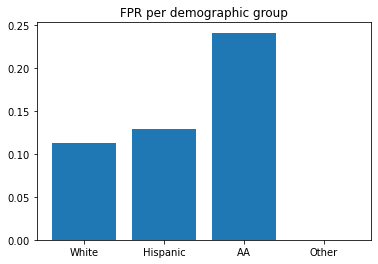

In [143]:
# report FPR for different demographic groups in demog_dev_df:
demog_dev_df_pred = pd.DataFrame({
    'is_offensive_true': demog_true_numeric,
    'is_offensive_pred': demog_pred_numeric,
    'demographic': prot_attr
})
demog_fpr  = {
    demog: fpr(
        y_true = demog_dev_df_pred[demog_dev_df_pred['demographic'] == demog]['is_offensive_true'],
        y_pred = demog_dev_df_pred[demog_dev_df_pred['demographic'] == demog]['is_offensive_pred']
    ) for demog in demog_dev_df_pred['demographic'].unique()
}

# plot
plt.figure()
plt.title('FPR per demographic group')
plt.bar(demog_fpr.keys(), demog_fpr.values())
plt.show()

In [144]:
demog_fpr.values()

dict_values([0.11216056670602124, 0.12835820895522387, 0.24096385542168675, 0.0])

In [145]:
np.std(list(demog_fpr.values()))

0.08538591971317144

In [146]:
demog_fpr_before = demog_fpr

# Pre-train the adversarial discriminator on `demographic_train.tsv`

In [16]:
# # filter data: remove examples with too many unknown words based on the main task's vocabulary
# def count_unk(text, vocab):
#     UNK_IDX = vocab.stoi['<UNK>']
#     token_ids = vocab.numericalize(text)
#     num_unk = token_ids.count(UNK_IDX)
#     return num_unk

# # count number of unknown tokens
# demographic_train_df['num_unk'] = demographic_train_df.apply(
#     lambda row : count_unk(row['text'], train_dataset.vocab),
#     axis = 1
# )
# demographic_dev_df['num_unk'] = demographic_dev_df.apply(
#     lambda row : count_unk(row['text'], train_dataset.vocab),
#     axis = 1
# )

# # filter
# demographic_train_df_filtered = demographic_train_df[demographic_train_df['num_unk'] <= 6]
# demographic_dev_df_filtered = demographic_dev_df[demographic_dev_df['num_unk'] <= 6]

# # resample each class to have the same number of examples
# n_samples_per_class = 140000
# demog_dfs = []
# for demog in demographic_train_df_filtered['demographic'].unique():
#     demog_df = demographic_train_df_filtered[demographic_train_df_filtered['demographic'] == demog]
#     demog_df_sample = demog_df.sample(n=n_samples_per_class)
#     demog_dfs.append(demog_df_sample)
# demographic_train_df_resampled = pd.concat(demog_dfs)

# n_samples_per_class = 48000
# demog_dfs = []
# for demog in demographic_dev_df_filtered['demographic'].unique():
#     demog_df = demographic_dev_df_filtered[demographic_dev_df_filtered['demographic'] == demog]
#     demog_df_sample = demog_df.sample(n=n_samples_per_class)
#     demog_dfs.append(demog_df_sample)
# demographic_dev_df_resampled = pd.concat(demog_dfs)

# # save
# demographic_train_df_resampled[['text', 'demographic']].sample(frac=1).to_csv(
#     'civility_extra_data/demographic_train_balanced.tsv', 
#     sep = '\t', 
#     index = False
# )
# demographic_dev_df_resampled[['text', 'demographic']].sample(frac=1).to_csv(
#     'civility_extra_data/demographic_dev_balanced.tsv', 
#     sep = '\t', 
#     index = False
# )

torch.Size([32, 256])


In [182]:
# load data
demographic_train_df = pd.read_csv('civility_extra_data/demographic_train_balanced.tsv', sep='\t')
demographic_dev_df = pd.read_csv('civility_extra_data/demographic_dev_balanced.tsv', sep='\t')

In [183]:
demographic_train_df.head()

,text,demographic
0,algebra hw is confusing me ._.,Hispanic
1,"Yeah, im single",Hispanic
2,@USER hola como estas,Hispanic
3,"El Verano, El Verano Es Azul",Other
4,"Holla if ya need me, ya always gonna be my boo, holla if ya need me, you know i still got youu",White


In [184]:
# create datasets
# but we need to overwrite the vocabulary with that of the main task
demographic_train_dataset = TextClassifierTrainDataset(
    df = demographic_train_df, 
    source_column = 'text', 
    target_column = 'demographic',
    class_names = demographic_train_df['demographic'].unique().tolist(),
    freq_threshold = 3,
    max_size = None,
    vocab = train_dataset.vocab
)
demographic_dev_dataset = TextClassifierInferenceDataset(
    train_dataset = demographic_train_dataset,
    df = demographic_dev_df,
    source_column = 'text', 
    target_column = 'demographic',
)

In [185]:
# create dataloaders
demographic_train_dataloader = get_train_loader(
    dataset = demographic_train_dataset, 
    batch_size = 128
)
demographic_dev_dataloader   = get_inference_loader(
    dataset = demographic_dev_dataset, 
    train_dataset = demographic_train_dataset,
    batch_size = 128
)

In [186]:
# initialize all necessary models

torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_IDX = train_dataset.vocab.stoi['<PAD>']
BOS_IDX = train_dataset.vocab.stoi['<SOS>']
EOS_IDX = train_dataset.vocab.stoi['<EOS>']

#==========================================================================================================================
# initialize main classifier with pre-trained weights
VOCAB_SIZE = len(train_dataset.vocab.stoi)
EMB_SIZE = 64
NHEAD = 4
FFN_HID_DIM = 256
NUM_ENCODER_LAYERS = 2
DROPOUT = 0.5
mainClassifier = TransformerClassifier(
    num_encoder_layers = NUM_ENCODER_LAYERS,
    emb_size = EMB_SIZE,
    nhead = NHEAD,
    vocab_size = VOCAB_SIZE,
    dim_feedforward = FFN_HID_DIM,
    dropout = DROPOUT,
    return_feature_vector = True
)
mainClassifier = mainClassifier.to(DEVICE)
cls_loss_fn = torch.nn.CrossEntropyLoss()
cls_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

checkpoint = torch.load('checkpoints/transformer_v1_14_valacc0.7817220543806647.model', map_location=DEVICE)
mainClassifier.load_state_dict(checkpoint['model_state_dict'])
cls_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Number of model parameters (main classifier):', count_parameters(mainClassifier))

#==========================================================================================================================
# initialize adversarial discriminator model
VOCAB_SIZE = len(demographic_train_dataset.vocab.stoi)
DISCRIMINATOR_IN_DIM = 256
DISCRIMINATOR_HIDDEN_SIZE = 128
DISCRIMINATOR_DROPOUT = 0.3

# initialize model
discriminator = DemographicDiscriminator(
    input_dim = DISCRIMINATOR_IN_DIM, 
    hidden_size = DISCRIMINATOR_HIDDEN_SIZE,
    num_classes = len(demographic_train_dataset.idx_to_class),
    dropout = DISCRIMINATOR_DROPOUT
)
for p in discriminator.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
discriminator = discriminator.to(DEVICE)
dsc_loss_fn = torch.nn.CrossEntropyLoss()
dsc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.003, betas=(0.9, 0.98), eps=1e-9)
print('Number of model parameters (adversarial discriminator):', count_parameters(discriminator))

#==========================================================================================================================
# combine with offensiveness classifier as feature extractor
combined_model = CombinedModel(
    mainClassifier = mainClassifier, 
    adversarialDiscriminator = discriminator
)
print('Number of model parameters (combined):', count_parameters(combined_model))

Number of model parameters (main classifier): 872194
Number of model parameters (adversarial discriminator): 33412
Number of model parameters (combined): 905606


In [89]:
def train_discriminator_epoch(combined_model, loss_fn, train_dataloader, optimizer, DEVICE):
    '''
    Trains the adversarial disciminator ONLY, keeping the main classifier's weights fixed
    '''
    for param in combined_model.mainClassifier.parameters():
        param.requires_grad = False
    combined_model.train()
    losses = 0
    for i, (src, tgt) in enumerate(train_dataloader):
                
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        _, discriminatorLogits = combined_model(src)
        
        optimizer.zero_grad()
        loss = loss_fn(discriminatorLogits.reshape(-1, discriminatorLogits.shape[-1]), tgt.reshape(-1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
        
        if i % 100 == 0:
            print(f'\rProcessing batch {i} of {len(train_dataloader)}: loss {loss}', end='', flush=True)

    return losses / len(train_dataloader)

def evaluate_discriminator(combined_model, loss_fn, val_dataloader, idx_to_class, DEVICE):
    '''
    Evaluates the loss and accuracy of the discriminator's predictions
    '''
    combined_model.eval()
    losses = 0

    # str_pred = []
    # str_true = []
    idx_pred = []
    idx_true = []
    for i, (src, tgt) in enumerate(val_dataloader):
                
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        _, discriminatorLogits = combined_model(src)

        # predictions of discriminator
        tgt_pred = torch.max(discriminatorLogits, dim=-1).indices  # (T, N)
        idx_pred.extend(tgt_pred.tolist())
        idx_true.extend(tgt.tolist())

        # # loop over examples in batch
        # for x in range(tgt_pred.shape[-1]):
        #     tgt_x      = tgt[x]
        #     tgt_pred_x = tgt_pred[x]
        #     tgt_x_string      = idx_to_class[tgt_x.tolist()]
        #     tgt_pred_x_string = idx_to_class[tgt_pred_x.tolist()]
        #     str_true.append(tgt_x_string)
        #     str_pred.append(tgt_pred_x_string)
        
        loss = loss_fn(discriminatorLogits.reshape(-1, discriminatorLogits.shape[-1]), tgt.reshape(-1))
        losses += loss.item()
        
        if i % 100 == 0:
            print(f'\rProcessing batch {i} of {len(val_dataloader)}: loss {loss}', end='', flush=True)

    print()
    return losses / len(val_dataloader), np.mean([int(te == pe) for te, pe in zip(idx_true, idx_pred)]), idx_true, idx_pred

In [91]:
# train the adversarial discriminator ONLY; keeping the main classifier's weights fixed
model = combined_model
NUM_EPOCHS = 50
PATIENCE = 5
best_val_f1 = -1
best_model_state_dict = None
epochs_since_last_improved = 0
for epoch in range(1, NUM_EPOCHS+1):

    # grab last best model if not improved for `patience` epochs
    if epochs_since_last_improved >= PATIENCE:
        print(f'{epochs_since_last_improved} epochs since last improved. Loading from checkpoint...')
        model.adversarialDiscriminator.load_state_dict(best_model_state_dict['model_state_dict'])
        optimizer.load_state_dict(best_model_state_dict['optimizer_state_dict'])
        epochs_since_last_improved = 0

    start_time = timer()

    # train one epoch
    train_loss = train_discriminator_epoch(
        combined_model = model, 
        loss_fn = dsc_loss_fn, 
        train_dataloader = demographic_train_dataloader, 
        optimizer = dsc_optimizer,
        DEVICE = DEVICE
    )

    # evaluate train and val set at end of epoch
    # train_loss, train_acc, train_true, train_pred = evaluate_discriminator(
    #     combined_model = model, 
    #     loss_fn = dsc_loss_fn, 
    #     val_dataloader = demographic_train_dataloader,
    #     idx_to_class = demographic_train_dataset.idx_to_class,
    #     DEVICE = DEVICE
    # )
    val_loss, val_acc, val_true, val_pred = evaluate_discriminator(
        combined_model = model, 
        loss_fn = dsc_loss_fn, 
        val_dataloader = demographic_dev_dataloader,
        idx_to_class = demographic_train_dataset.idx_to_class,
        DEVICE = DEVICE
    )
    val_f1 = f1_score(val_true, val_pred, average='macro')  # penalizes bad performance on minority classs
    
    end_time = timer()

    # checkpoint if train acc is better than last
    if val_f1 > best_val_f1:
        print(f'New best model found! saving...')
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.adversarialDiscriminator.state_dict(),
            'optimizer_state_dict': dsc_optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1
        }
        torch.save(state_dict, f'checkpoints/discriminator_v1_{epoch}_valf1{val_f1}.model')
        best_val_f1 = val_f1
        best_model_state_dict = state_dict
        epochs_since_last_improved = 0
    else:
        epochs_since_last_improved += 1

    print()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Epoch: {epoch}, Val loss  : {val_loss:.3f}, Val acc  : {val_acc:.3f},   Val F1  : {val_f1:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
           
    print("================================================================================================================")



Processing batch 1400 of 1500: loss 1.3362728357315063
New best model found! saving...

Epoch: 1, Train loss: 1.246, Epoch time = 37.285s
Epoch: 1, Val loss  : 1.374, Val acc  : 0.378,   Val F1  : 0.295 Epoch time = 37.285s
Processing batch 1400 of 1500: loss 1.3377085924148568

Epoch: 2, Train loss: 1.235, Epoch time = 37.938s
Epoch: 2, Val loss  : 1.363, Val acc  : 0.365,   Val F1  : 0.281 Epoch time = 37.938s
Processing batch 1400 of 1500: loss 1.2962299585342407

Epoch: 3, Train loss: 1.234, Epoch time = 37.183s
Epoch: 3, Val loss  : 1.329, Val acc  : 0.375,   Val F1  : 0.292 Epoch time = 37.183s
Processing batch 1400 of 1500: loss 1.3028684854507446
New best model found! saving...

Epoch: 4, Train loss: 1.233, Epoch time = 37.361s
Epoch: 4, Val loss  : 1.341, Val acc  : 0.380,   Val F1  : 0.298 Epoch time = 37.361s
Processing batch 1400 of 1500: loss 1.2552243471145634
New best model found! saving...

Epoch: 5, Train loss: 1.233, Epoch time = 40.161s
Epoch: 5, Val loss  : 1.282, V

KeyboardInterrupt: 

In [187]:
# load model
checkpoint = torch.load('checkpoints/discriminator_v1_5_valf10.34552287643483504.model', map_location=DEVICE)
model.adversarialDiscriminator.load_state_dict(checkpoint['model_state_dict'])
dsc_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(DEVICE)
model.eval()

CombinedModel(
  (mainClassifier): TransformerClassifier(
    (src_tok_emb): TokenEmbedding(
      (embedding): Embedding(4574, 64)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(

In [188]:
checkpoint['val_acc']

0.42036979166666666

In [94]:
val_loss, val_acc, val_true, val_pred = evaluate_discriminator(
    combined_model = model, 
    loss_fn = dsc_loss_fn, 
    val_dataloader = demographic_dev_dataloader,
    idx_to_class = demographic_train_dataset.idx_to_class,
    DEVICE = DEVICE
)
val_f1 = f1_score(val_true, val_pred, average='macro')  # penalizes bad performance on minority classs
print(val_f1)

Processing batch 1400 of 1500: loss 1.1966357231140137
0.34552287643483504


In [102]:
from sklearn.metrics import confusion_matrix
val_true_str = [demographic_train_dataset.idx_to_class[x] for x in val_true]
val_pred_str = [demographic_train_dataset.idx_to_class[x] for x in val_pred]
confusion_matrix(val_true_str, val_pred_str, labels=list(demographic_train_dataset.idx_to_class.values()))

array([[ 1493, 23045, 16508,  6954],
       [   29, 45981,  1819,   171],
       [ 1772, 18333, 22784,  5111],
       [ 1449, 26440,  9658, 10453]], dtype=int64)

In [103]:
demographic_train_dataset.idx_to_class

{0: 'Hispanic', 1: 'Other', 2: 'White', 3: 'AA'}

Not very good, but it's not the discriminator's fault; it has limited control over the features that the main classifier (which serves as feature extractor) learns. This just tells us that the main classifier is not that biased to begin with (which is good)

# Train adversarially

In [4]:
def train_epoch_adversarial(
    combined_model, 
    cls_loss_fn, 
    dsc_loss_fn, 
    train_dataloader, 
    combined_optimizer,
    DEVICE
):
    
    '''
    Train the main classifier with the adversarial objective, but freeze the adversarial discriminator's weights
    '''
    
    # unfreeze main classifier weights
    # for param in combined_model.mainClassifier.parameters():
    #     param.requires_grad = True
    
    # freeze discriminator weights
    for param in combined_model.adversarialDiscriminator.parameters():
        param.requires_grad = False
    
    # generate a uniform distribution over demographic classes as target for adversarial discriminator
    uniform_tensor = torch.ones([128, 4]) / 4
    uniform_tensor = uniform_tensor.to(DEVICE)
    
    # combined_model.to(DEVICE)
    combined_model.train()
    cls_losses = 0
    dsc_losses = 0
    total_losses = 0
    for i, (src, cls_tgt) in enumerate(train_dataloader):
                
        # forward pass, obtaining output logits of both heads
        src = src.to(DEVICE)
        cls_tgt = cls_tgt.to(DEVICE)
        dsc_tgt = uniform_tensor[:len(cls_tgt)]
        mainClassifierLogits, discriminatorLogits = combined_model(src)
        
        # calculate gradients based on both losses
        dsc_loss_weight = 1
        cls_optimizer.zero_grad()
        dsc_optimizer.zero_grad()
        cls_loss = cls_loss_fn(mainClassifierLogits.reshape(-1, mainClassifierLogits.shape[-1]), cls_tgt.reshape(-1))
        dsc_loss = dsc_loss_fn(discriminatorLogits, dsc_tgt)
        total_loss = cls_loss + dsc_loss_weight * dsc_loss
        # total_loss = dsc_loss
        total_loss.backward()

        # update weights based on combined loss
        combined_optimizer.step()
        
        cls_losses += cls_loss.item()
        dsc_losses += dsc_loss.item()
        total_losses += total_loss.item()
        
        if i % 10 == 0:
            print(f'\rProcessing batch {i} of {len(train_dataloader)}: cls_loss {cls_loss:.4f}, dsc_loss {dsc_loss:.4f}, total loss {total_loss:.4f}', end='', flush=True)
    
    print()
    return total_losses / len(train_dataloader)


def evaluate_adversarial(
    combined_model, 
    cls_loss_fn, 
    dsc_loss_fn, 
    val_dataloader, 
    DEVICE
):
    '''
    Evaluates the loss and accuracy of the discriminator's predictions
    '''
    # combined_model.to(DEVICE)
    combined_model.eval()
    
    # tracking for main classification task
    cls_losses = 0
    cls_idx_pred = []
    cls_idx_true = []
    
    # tracking for adversarial task
    dsc_losses = 0
    dsc_idx_logits = []
    dsc_idx_pred = []
    
    # generate a uniform distribution over demographic classes as target for adversarial discriminator
    uniform_tensor = torch.ones([128, 4]) / 4
    uniform_tensor = uniform_tensor.to(DEVICE)
    
    softmax = nn.Softmax(dim=1)
    total_losses = 0
    for i, (src, cls_tgt) in enumerate(val_dataloader):
                
        # forward pass, obtaining output logits of both heads
        src = src.to(DEVICE)
        cls_tgt = cls_tgt.to(DEVICE)
        dsc_tgt = uniform_tensor[:len(cls_tgt)]
        mainClassifierLogits, discriminatorLogits = combined_model(src)

        # predictions of main classifier
        cls_tgt_pred = torch.max(mainClassifierLogits, dim=-1).indices  # (T, N)
        cls_idx_pred.extend(cls_tgt_pred.cpu().detach().numpy().tolist())
        cls_idx_true.extend(cls_tgt.cpu().detach().numpy().tolist())
        
        # predictions of discriminator, in probability distribution form
        dsc_idx_probs = softmax(discriminatorLogits)
        dsc_idx_pred.append(dsc_idx_probs.cpu().detach().numpy())
        dsc_idx_logits.append(discriminatorLogits.cpu().detach().numpy())
        
        # calculate losses
        dsc_loss_weight = 1
        cls_loss = cls_loss_fn(mainClassifierLogits.reshape(-1, mainClassifierLogits.shape[-1]), cls_tgt.reshape(-1))
        dsc_loss = dsc_loss_fn(discriminatorLogits, dsc_tgt)
        total_loss = cls_loss + dsc_loss_weight * dsc_loss
        
        cls_losses += cls_loss.item()
        dsc_losses += dsc_loss.item()
        total_losses += total_loss.item()
        
        if i % 10 == 0:
            print(f'\rProcessing batch {i} of {len(val_dataloader)}: loss {total_loss}', end='', flush=True)

    print()
    return \
        total_losses / len(val_dataloader), \
        cls_losses   / len(val_dataloader), \
        dsc_losses   / len(val_dataloader), \
        np.mean([int(te == pe) for te, pe in zip(cls_idx_true, cls_idx_pred)]), \
        cls_idx_true, \
        cls_idx_pred, \
        np.concatenate(dsc_idx_logits), \
        np.concatenate(dsc_idx_pred)

In [5]:
# train data 
train_df = pd.read_csv('civility_data/train.tsv', sep='\t')
print(train_df.shape)

# extra_data
extra_df = pd.read_csv('civility_extra_data/labeled_data.tsv', sep='\t')
print(extra_df.shape)

# dev data
dev_df = pd.read_csv('civility_data/dev.tsv', sep='\t')
print(dev_df.shape)

# demog dev: for FPR disparity
demog_dev_df = pd.read_csv('civility_data/mini_demographic_dev.tsv', sep='\t')
demog_dev_df['label'] = 'NOT'
print(demog_dev_df.shape)

(10592, 3)
(24783, 7)
(1324, 4)
(5072, 4)


In [6]:
# create datasets
train_dataset = TextClassifierTrainDataset(
    df = train_df, 
    source_column = 'text', 
    target_column = 'label',
    class_names = train_df['label'].unique().tolist(),
    freq_threshold = 3,
    max_size = None
)
val_dataset = TextClassifierInferenceDataset(
    train_dataset = train_dataset,
    df = dev_df, # val_df, 
    source_column = 'text', 
    target_column = 'label',
)
demog_dev_dataset = TextClassifierInferenceDataset(
    train_dataset = train_dataset,
    df = demog_dev_df, 
    source_column = 'text', 
    target_column = 'label',
    protected_attribute_column = 'demographic',
    protected_attribute_names = demog_dev_df['demographic'].unique().tolist(),
    protected_attribute_source = 'self'
)

In [7]:
# create dataloaders
train_dataloader = get_train_loader(
    dataset = train_dataset, 
    batch_size = 32
)
train_eval_dataloader = get_inference_loader(
    dataset = train_dataset, 
    train_dataset = train_dataset,
    batch_size = 32
)
val_dataloader   = get_inference_loader(
    dataset = val_dataset, 
    train_dataset = train_dataset,
    batch_size = 32
)
demog_dev_dataloader = get_inference_loader(
    dataset = demog_dev_dataset, 
    train_dataset = train_dataset,
    batch_size = 32,
    return_protected_attribute = True
)

In [8]:
# initialize all necessary models

torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_IDX = train_dataset.vocab.stoi['<PAD>']
BOS_IDX = train_dataset.vocab.stoi['<SOS>']
EOS_IDX = train_dataset.vocab.stoi['<EOS>']

#==========================================================================================================================
# initialize main classifier with pre-trained weights
VOCAB_SIZE = len(train_dataset.vocab.stoi)
EMB_SIZE = 64
NHEAD = 4
FFN_HID_DIM = 256
NUM_ENCODER_LAYERS = 2
DROPOUT = 0.5
mainClassifier = TransformerClassifier(
    num_encoder_layers = NUM_ENCODER_LAYERS,
    emb_size = EMB_SIZE,
    nhead = NHEAD,
    vocab_size = VOCAB_SIZE,
    dim_feedforward = FFN_HID_DIM,
    dropout = DROPOUT,
    return_feature_vector = True
)
mainClassifier = mainClassifier.to(DEVICE)
cls_loss_fn = torch.nn.CrossEntropyLoss()
cls_optimizer = torch.optim.Adam(mainClassifier.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
print('Number of model parameters (main classifier):', count_parameters(mainClassifier))

#==========================================================================================================================
# initialize adversarial discriminator model
VOCAB_SIZE = len(train_dataset.vocab.stoi)
DISCRIMINATOR_IN_DIM = 256
DISCRIMINATOR_HIDDEN_SIZE = 128
DISCRIMINATOR_DROPOUT = 0.3

# initialize model
discriminator = DemographicDiscriminator(
    input_dim = DISCRIMINATOR_IN_DIM, 
    hidden_size = DISCRIMINATOR_HIDDEN_SIZE,
    num_classes = 4,  # white, AA, hispanic, other
    dropout = DISCRIMINATOR_DROPOUT
)
discriminator = discriminator.to(DEVICE)
dsc_loss_fn = torch.nn.CrossEntropyLoss()
dsc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.003, betas=(0.9, 0.98), eps=1e-9)
print('Number of model parameters (adversarial discriminator):', count_parameters(discriminator))

#==========================================================================================================================
# combine with offensiveness classifier as feature extractor
combined_model = CombinedModel(
    mainClassifier = mainClassifier, 
    adversarialDiscriminator = discriminator
)

# load main classifier weights
cls_checkpoint = torch.load('checkpoints/transformer_v1_14_valacc0.7817220543806647.model', map_location=DEVICE)
combined_model.mainClassifier.load_state_dict(cls_checkpoint['model_state_dict'])

# load discriminator weights
dsc_checkpoint = torch.load('checkpoints/discriminator_v1_5_valf10.34552287643483504.model', map_location=DEVICE)
combined_model.adversarialDiscriminator.load_state_dict(dsc_checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

combined_model.to(DEVICE)
print('Number of model parameters (combined):', count_parameters(combined_model))

Number of model parameters (main classifier): 872194
Number of model parameters (adversarial discriminator): 33412
Number of model parameters (combined): 905606


In [10]:
# sanity check: before adversarial training,
# discriminator's outputs should indicate that demographic is clearly predictable from the shared representation
val_loss, val_cls_loss, val_dsc_loss, val_acc, val_true, val_pred, val_dsc_pred_logits, val_dsc_pred_probs = evaluate_adversarial(
    combined_model = combined_model, 
    cls_loss_fn = cls_loss_fn, 
    dsc_loss_fn = dsc_loss_fn, 
    val_dataloader = val_dataloader,
    DEVICE = DEVICE
)
val_f1 = f1_score(val_true, val_pred)
val_dsc_loss

Processing batch 40 of 42: loss 2.4127669334411626


1.8222176205544245

In [11]:
test_df = pd.read_csv('civility_data/test.tsv', sep='\t')
test_df['dummy_label'] = 'NOT'

test_dataset = TextClassifierInferenceDataset(
    train_dataset = train_dataset,
    df = test_df,
    source_column = 'text', 
    target_column = 'dummy_label',
)

test_dataloader   = get_inference_loader(
    dataset = test_dataset, 
    train_dataset = train_dataset,
    batch_size = 32
)

val_loss, val_cls_loss, val_dsc_loss, val_acc, val_true, val_pred, val_dsc_pred_logits, val_dsc_pred_probs = evaluate_adversarial(
    combined_model = combined_model, 
    cls_loss_fn = cls_loss_fn, 
    dsc_loss_fn = dsc_loss_fn, 
    val_dataloader = test_dataloader,
    DEVICE = DEVICE
)

val_pred_str = [train_dataset.idx_to_class[x] for x in val_pred]

test_df['label'] = val_pred_str

test_df[['text', 'label']].to_csv('IgnatiusHarisSetiawan_Widjaja_test.tsv', sep='\t', index=False)

Processing batch 190 of 200: loss 1.7995187044143677


C:\Users\haris\AppData\Local\Temp/ipykernel_21716/1106396005.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[row, col].set_xticks([])
C:\Users\haris\AppData\Local\Temp/ipykernel_21716/1106396005.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[row, col].set_xticks([])
C:\Users\haris\AppData\Local\Temp/ipykernel_21716/1106396005.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[row, col].set_xticks([])
C:\Users\haris\AppData\Local\Temp/ipykernel_21716/1106396005.py:26: MatplotlibDeprecationWarning: Support for passing numbers t

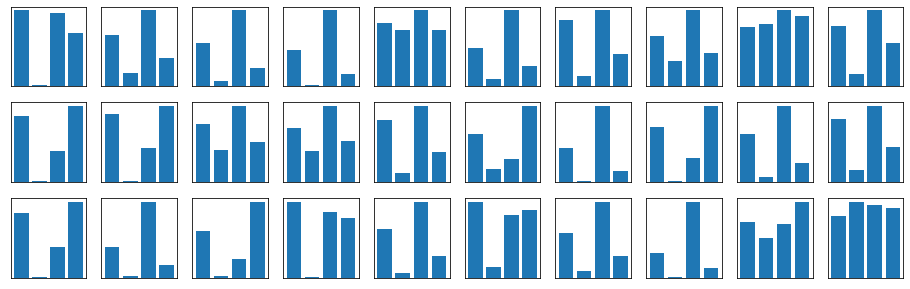

In [118]:
from matplotlib import pyplot as plt
from math import log2

# custom crossentropy
def cross_entropy(p, q):
    return -sum([p[i]*log2(q[i]) for i in range(len(p))])

num_rows = 3
num_cols = 10
pick_ids = np.random.choice(np.arange(len(val_dsc_pred_probs)), size=num_rows*num_cols, replace=False)
demogs = ['Hispanic', 'Other', 'White', 'AA']
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16,5))
for i in range(num_rows*num_cols):
    
    # determine location in plot
    row = i // num_cols
    col = i % num_cols
    
    # grab probabilities and logits
    example_id = pick_ids[i]
    val_dsc_pred_probs_i = val_dsc_pred_probs[example_id:example_id+1]
    val_dsc_pred_logits_i = val_dsc_pred_logits[example_id:example_id+1]
    
    # plot in the correct place
    axs[row, col].bar(demogs, val_dsc_pred_probs_i.squeeze())
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])

In [ ]:
for name, param in combined_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [119]:
# train the main classifier ONLY, but with the adversarial objective; keeping the adversarial discriminator's weights fixed
model = combined_model
NUM_EPOCHS = 20
PATIENCE = 5
best_val_dsc_loss = 10000
best_model_state_dict = None
epochs_since_last_improved = 0
for epoch in range(1, NUM_EPOCHS+1):

    # grab last best model if not improved for `patience` epochs
    if epochs_since_last_improved >= PATIENCE:
        print(f'{epochs_since_last_improved} epochs since last improved. Loading from checkpoint...')
        model.load_state_dict(best_model_state_dict['model_state_dict'])
        optimizer.load_state_dict(best_model_state_dict['optimizer_state_dict'])
        epochs_since_last_improved = 0

    start_time = timer()

    # train one epoch
    train_loss = train_epoch_adversarial(
        combined_model = model, 
        cls_loss_fn = cls_loss_fn, 
        dsc_loss_fn = dsc_loss_fn, 
        train_dataloader = train_dataloader, 
        combined_optimizer = optimizer,  # combined optimizer
        DEVICE = DEVICE
    )

    # evaluate train and val set at end of epoch
    train_loss, train_cls_loss, train_dsc_loss, train_acc, train_true, train_pred, train_dsc_pred_logits, train_dsc_pred_probs = evaluate_adversarial(
        combined_model = combined_model, 
        cls_loss_fn = cls_loss_fn, 
        dsc_loss_fn = dsc_loss_fn, 
        val_dataloader = train_eval_dataloader,
        DEVICE = DEVICE # torch.device('cpu')
    )
    val_loss, val_cls_loss, val_dsc_loss, val_acc, val_true, val_pred, val_dsc_pred_logits, val_dsc_pred_probs = evaluate_adversarial(
        combined_model = combined_model, 
        cls_loss_fn = cls_loss_fn, 
        dsc_loss_fn = dsc_loss_fn, 
        val_dataloader = val_dataloader,
        DEVICE = DEVICE # torch.device('cpu')
    )
    val_f1 = f1_score(val_true, val_pred)
    
    end_time = timer()

    # checkpoint if train acc is better than last
    if val_dsc_loss < best_val_dsc_loss:
        print(f'New best model found! saving...')
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_cls_loss': train_cls_loss,
            'train_dsc_loss': train_dsc_loss,
            'val_cls_loss': val_cls_loss,
            'val_dsc_loss': val_dsc_loss,
            'val_cls_acc': val_acc,
            'val_cls_f1': val_f1
        }
        torch.save(state_dict, f'checkpoints/combined_v1_{epoch}_valdscloss{val_dsc_loss:.6f}_valf1{val_f1:.6f}.model')
        best_val_dsc_loss = val_dsc_loss
        best_model_state_dict = state_dict
        epochs_since_last_improved = 0
    else:
        epochs_since_last_improved += 1

    print()
    print((f"Epoch: {epoch}, Train cls loss: {train_cls_loss:.3f}, dsc loss: {train_dsc_loss:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Epoch: {epoch}, Val cls loss  : {val_cls_loss:.3f}, dsc loss: {val_dsc_loss:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Epoch: {epoch}, Val cls acc   : {val_acc:.3f}, F1: {val_f1:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
    
    print("================================================================================================================")



Processing batch 330 of 331: cls_loss 0.3168, dsc_loss 1.4334, total loss 1.7502
Processing batch 330 of 331: loss 1.7685060501098633
Processing batch 40 of 42: loss 1.8574019670486458
New best model found! saving...

Epoch: 1, Train cls loss: 0.433, dsc loss: 1.421 Epoch time = 5.044s
Epoch: 1, Val cls loss  : 0.592, dsc loss: 1.420 Epoch time = 5.044s
Epoch: 1, Val cls acc   : 0.780, F1: 0.850 Epoch time = 5.044s
Processing batch 330 of 331: cls_loss 0.3434, dsc_loss 1.4162, total loss 1.7596
Processing batch 330 of 331: loss 1.7580800056457522
Processing batch 40 of 42: loss 1.7813484668731696
New best model found! saving...

Epoch: 2, Train cls loss: 0.459, dsc loss: 1.405 Epoch time = 5.113s
Epoch: 2, Val cls loss  : 0.628, dsc loss: 1.403 Epoch time = 5.113s
Epoch: 2, Val cls acc   : 0.779, F1: 0.851 Epoch time = 5.113s
Processing batch 330 of 331: cls_loss 0.3657, dsc_loss 1.4161, total loss 1.7818
Processing batch 330 of 331: loss 1.7239302396774292
Processing batch 40 of 42: l

Processing batch 330 of 331: cls_loss 0.2306, dsc_loss 1.4153, total loss 1.6459
Processing batch 330 of 331: loss 1.6655876636505127
Processing batch 40 of 42: loss 1.7429814338684082

Epoch: 17, Train cls loss: 0.393, dsc loss: 1.391 Epoch time = 5.160s
Epoch: 17, Val cls loss  : 0.703, dsc loss: 1.391 Epoch time = 5.160s
Epoch: 17, Val cls acc   : 0.764, F1: 0.837 Epoch time = 5.160s
Processing batch 330 of 331: cls_loss 0.2690, dsc_loss 1.4153, total loss 1.6843
Processing batch 330 of 331: loss 1.6587021350860596
Processing batch 40 of 42: loss 1.7690533399581914

Epoch: 18, Train cls loss: 0.388, dsc loss: 1.391 Epoch time = 5.233s
Epoch: 18, Val cls loss  : 0.708, dsc loss: 1.391 Epoch time = 5.233s
Epoch: 18, Val cls acc   : 0.764, F1: 0.836 Epoch time = 5.233s
Processing batch 330 of 331: cls_loss 0.2481, dsc_loss 1.4089, total loss 1.6570
Processing batch 330 of 331: loss 1.6573427915573126
Processing batch 40 of 42: loss 1.7935678958892822

Epoch: 19, Train cls loss: 0.362, 

In [79]:
for name, param in combined_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

mainClassifier.src_tok_emb.embedding.weight tensor([[ 0.0724, -0.0463,  0.0273,  ...,  0.0577, -0.0026, -0.0456],
        [ 0.0668, -0.0175, -0.0228,  ...,  0.0215,  0.0075, -0.0584],
        [ 0.0368, -0.0101,  0.0330,  ...,  0.0347,  0.0024, -0.0315],
        ...,
        [ 0.0462, -0.0182, -0.0246,  ...,  0.0348,  0.0181,  0.0350],
        [ 0.0350,  0.0076,  0.0281,  ..., -0.0118, -0.0127, -0.0147],
        [ 0.0443, -0.0459, -0.0471,  ...,  0.0217,  0.0472,  0.0619]],
       device='cuda:0')
mainClassifier.transformer_encoder.layers.0.self_attn.in_proj_weight tensor([[ 0.1580, -0.0686,  0.1058,  ...,  0.1266,  0.0599, -0.1456],
        [ 0.0763, -0.1274,  0.0191,  ...,  0.0812,  0.1610, -0.0870],
        [ 0.0551,  0.0456, -0.1268,  ..., -0.1498, -0.1106, -0.1280],
        ...,
        [-0.0047,  0.1439,  0.0337,  ...,  0.0061,  0.0232, -0.0387],
        [ 0.1224, -0.0628, -0.1126,  ..., -0.0320,  0.1756, -0.0564],
        [ 0.0357, -0.0573,  0.1219,  ..., -0.1272,  0.2129,  0.134

mainClassifier.classifier.bias tensor([-0.0600, -0.0126], device='cuda:0')


In [8]:
# load combined model weights
checkpoint = torch.load('checkpoints/combined_v1_3_valdscloss1.395304_valf10.851699.model', map_location=DEVICE)
combined_model.load_state_dict(checkpoint['model_state_dict'])

val_loss, val_cls_loss, val_dsc_loss, val_acc, val_true, val_pred, val_dsc_pred_logits, val_dsc_pred_probs = evaluate_adversarial(
    combined_model = combined_model, 
    cls_loss_fn = cls_loss_fn, 
    dsc_loss_fn = dsc_loss_fn, 
    val_dataloader = val_dataloader,
    DEVICE = DEVICE
)
val_f1 = f1_score(val_true, val_pred)
print(val_acc, val_f1)

Processing batch 40 of 42: loss 1.7775783538818366
0.7824773413897281 0.8516992790937178


C:\Users\haris\AppData\Local\Temp/ipykernel_21716/171138243.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[row, col].set_xticks([])
C:\Users\haris\AppData\Local\Temp/ipykernel_21716/171138243.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[row, col].set_xticks([])
C:\Users\haris\AppData\Local\Temp/ipykernel_21716/171138243.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[row, col].set_xticks([])
C:\Users\haris\AppData\Local\Temp/ipykernel_21716/171138243.py:22: MatplotlibDeprecationWarning: Support for passing numbers throu

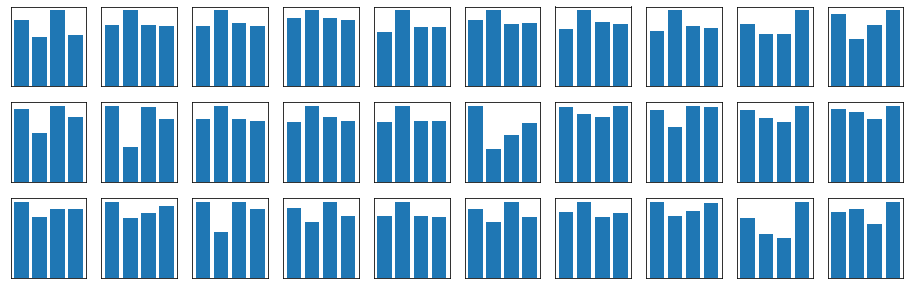

In [174]:
from matplotlib import pyplot as plt

num_rows = 3
num_cols = 10
# use the same IDs as previously; don't sample again
# pick_ids = np.random.choice(np.arange(len(val_dsc_pred_probs)), size=num_rows*num_cols, replace=False)
demogs = ['Hispanic', 'Other', 'White', 'AA']
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16,5))
for i in range(num_rows*num_cols):
    
    # determine location in plot
    row = i // num_cols
    col = i % num_cols
    
    # grab probabilities and logits
    example_id = pick_ids[i]
    val_dsc_pred_probs_i = val_dsc_pred_probs[example_id:example_id+1]
    val_dsc_pred_logits_i = val_dsc_pred_logits[example_id:example_id+1]
    
    # plot in the correct place
    axs[row, col].bar(demogs, val_dsc_pred_probs_i.squeeze())
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])

# Evaluate adversarially trained network on `demog_dev_df`

In [175]:
demog_loss, demog_acc, demog_true, demog_pred, prot_attr = evaluate_with_protected_attribute(
    model = combined_model.mainClassifier, 
    loss_fn = cls_loss_fn, 
    val_dataloader = demog_dev_dataloader,
    idx_to_class = train_dataset.idx_to_class,
    idx_to_prot_attr = demog_dev_dataset.idx_to_prot_attr,
    DEVICE = DEVICE
)
demog_true_numeric = np.array([1 if x == 'OFF' else 0 for x in demog_true])
demog_pred_numeric = np.array([1 if x == 'OFF' else 0 for x in demog_pred])
demog_f1 = f1_score(1-demog_true_numeric, 1-demog_pred_numeric)

Processing batch 150 of 159: loss 0.23937173187732697


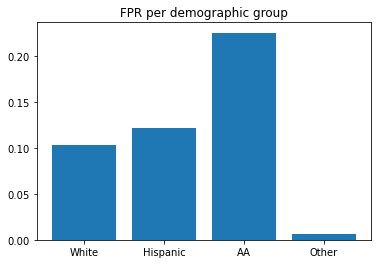

In [176]:
# report FPR for different demographic groups in demog_dev_df:
demog_dev_df_pred = pd.DataFrame({
    'is_offensive_true': demog_true_numeric,
    'is_offensive_pred': demog_pred_numeric,
    'demographic': prot_attr
})
demog_fpr  = {
    demog: fpr(
        y_true = demog_dev_df_pred[demog_dev_df_pred['demographic'] == demog]['is_offensive_true'],
        y_pred = demog_dev_df_pred[demog_dev_df_pred['demographic'] == demog]['is_offensive_pred']
    ) for demog in demog_dev_df_pred['demographic'].unique()
}

# plot
plt.figure()
plt.title('FPR per demographic group')
plt.bar(demog_fpr.keys(), demog_fpr.values())
plt.show()

In [177]:
demog_fpr.values()

dict_values([0.1038961038961039, 0.12238805970149254, 0.22590361445783133, 0.0058823529411764705])

In [178]:
np.std(list(demog_fpr.values()))

0.07807563870329791

<AxesSubplot:xlabel='demographic'>

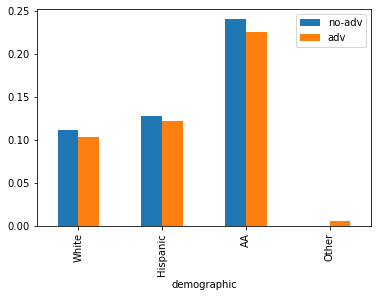

In [179]:
# side by side
demogs = list(demog_fpr.keys())
demog_fpr_comparison_df = pd.DataFrame({
    'demographic': demogs,
    'no-adv': [demog_fpr_before[demog] for demog in demogs],
    'adv': [demog_fpr[demog] for demog in demogs]
})
demog_fpr_comparison_df.plot(x = 'demographic', y = ['no-adv', 'adv'], kind='bar')

# Predict on `test.tsv`

In [16]:
test_df = pd.read_csv('civility_data/test.tsv', sep='\t')
test_df['dummy_label'] = 'NOT'

test_dataset = TextClassifierInferenceDataset(
    train_dataset = train_dataset,
    df = test_df,
    source_column = 'text', 
    target_column = 'dummy_label',
)

test_dataloader   = get_inference_loader(
    dataset = test_dataset, 
    train_dataset = train_dataset,
    batch_size = 32
)

val_loss, val_cls_loss, val_dsc_loss, val_acc, val_true, val_pred, val_dsc_pred_logits, val_dsc_pred_probs = evaluate_adversarial(
    combined_model = combined_model, 
    cls_loss_fn = cls_loss_fn, 
    dsc_loss_fn = dsc_loss_fn, 
    val_dataloader = test_dataloader,
    DEVICE = DEVICE
)

val_pred_str = [train_dataset.idx_to_class[x] for x in val_pred]

test_df['label'] = val_pred_str

test_df[['text', 'label']].to_csv('IgnatiusHarisSetiawan_Widjaja_advanced.tsv', sep='\t', index=False)

In [35]:
# sanity check
for i, (src, cls_tgt) in enumerate(test_dataloader):

    # forward pass, obtaining output logits of both heads
    src = src.to(DEVICE)
    cls_tgt = cls_tgt.to(DEVICE)
    
    break
    
i = 2
token_ids = src.cpu().detach().numpy().T[i].tolist()
token_str = [train_dataset.vocab.itos[t] for t in token_ids]
token_str

['<SOS>',
 'you',
 'know',
 'what',
 'i',
 'hate',
 '?',
 '<UNK>',
 '.',
 '<EOS>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']